In [2]:
#Imports
from collections import Counter
import pandas as pd
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import glob
from sklearn.model_selection import train_test_split
from Bio import pairwise2 
import math
import pdb

In [48]:
#the first column gives the peptide, 
#the second column the log50k transformed binding affinity (i.e. 1 - log50k( aff nM)), 
#and the last column the class II allele.
train = pd.read_csv('/home/pbryant/data/MHCII/panmhc/train1', sep='\t', header = None)
test = pd.read_csv('/home/pbryant/data/MHCII/panmhc/test1', sep='\t', header = None)

In [49]:
#Rename columns
test = test.rename({0: 'peptide_seq', 1: 'log50k', 2:'allele'}, axis=1)
train = train.rename({0: 'peptide_seq', 1: 'log50k', 2:'allele'}, axis=1)

In [28]:
#Read and rename columns of the other splits
for i in range(2,6):
    train = pd.read_csv('/home/pbryant/data/MHCII/panmhc/train'+str(i), sep='\t', header = None)
    test = pd.read_csv('/home/pbryant/data/MHCII/panmhc/test'+str(i), sep='\t', header = None)
    #Rename columns
    test = test.rename({0: 'peptide_seq', 1: 'log50k', 2:'allele'}, axis=1)
    train = train.rename({0: 'peptide_seq', 1: 'log50k', 2:'allele'}, axis=1)
    train.to_csv('/home/pbryant/MHCII/pan/split'+str(i)+'/train'+str(i)+'.csv')
    test.to_csv('/home/pbryant/MHCII/pan/split'+str(i)+'/test'+str(i)+'.csv')


In [31]:
#Encode amino acids for peptides
for i in range(2,6):
    peptide_enc = []
    df = pd.read_csv('/home/pbryant/MHCII/pan/split'+str(i)+'/train'+str(i)+'.csv')
    print(df.columns)
    peptides = df['peptide_seq']
    for seq in peptides:
        enc = encode_aa(seq)
        peptide_enc.append(np.asarray(enc))

    peptide_enc = np.asarray(peptide_enc)
    np.save('/home/pbryant/MHCII/pan/split'+str(i)+'/train_aa_enc'+str(i)+'.npy', peptide_enc)
    
    peptide_enc = []
    df = pd.read_csv('/home/pbryant/MHCII/pan/split'+str(i)+'/test'+str(i)+'.csv')
    print(df.columns)
    peptides = df['peptide_seq']
    for seq in peptides:
        enc = encode_aa(seq)
        peptide_enc.append(np.asarray(enc))

    peptide_enc = np.asarray(peptide_enc)
    np.save('/home/pbryant/MHCII/pan/split'+str(i)+'/test_aa_enc'+str(i)+'.npy', peptide_enc)

Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')
Index(['Unnamed: 0', 'peptide_seq', 'log50k', 'allele'], dtype='object')


In [28]:
test_alleles = Counter(test['allele'])
train_alleles = Counter(train['allele'])
testa = [*test_alleles.keys()]
traina = [*train_alleles.keys()]
print('train:',len(traina), 'test:',len(testa))
diff = []
for a in traina:
    if a not in testa:
        diff.append(a)
        print(a)

train: 80 test: 73
HLA-DQA10103-DQB10302
HLA-DQA10302-DQB10303
HLA-DQA10505-DQB10301
DRB1_1402
DRB1_0803
HLA-DQA10301-DQB10201
DRB1_1503


In [208]:
#Check if alleles in test are not in train
for a in testa:
    if a not in traina:
        print(a)

In [30]:
#looking into the difference btw the train and test set - Basically no difference, since the differing
#alleles have such low representation in the dataset
for a in diff:
    print(a,train_alleles[a])

HLA-DQA10103-DQB10302 6
HLA-DQA10302-DQB10303 6
HLA-DQA10505-DQB10301 1
DRB1_1402 1
DRB1_0803 8
HLA-DQA10301-DQB10201 4
DRB1_1503 1


In [71]:
#Encode alleles
allele_enc = dict(zip(traina, range(0,len(traina))))

In [74]:
#Encode alleles for train set
allele_encs = []
for index, row in train.iterrows():
    al = row['allele']
    allele_encs.append(allele_enc[al])
train['allele_enc'] = allele_encs
train.to_csv('/home/pbryant/MHCII/pan/train.csv')

In [75]:
#Encode alleles for test set
allele_encs = []
for index, row in test.iterrows():
    al = row['allele']
    allele_encs.append(allele_enc[al])
test['allele_enc'] = allele_encs
test.to_csv('/home/pbryant/MHCII/pan/test.csv')

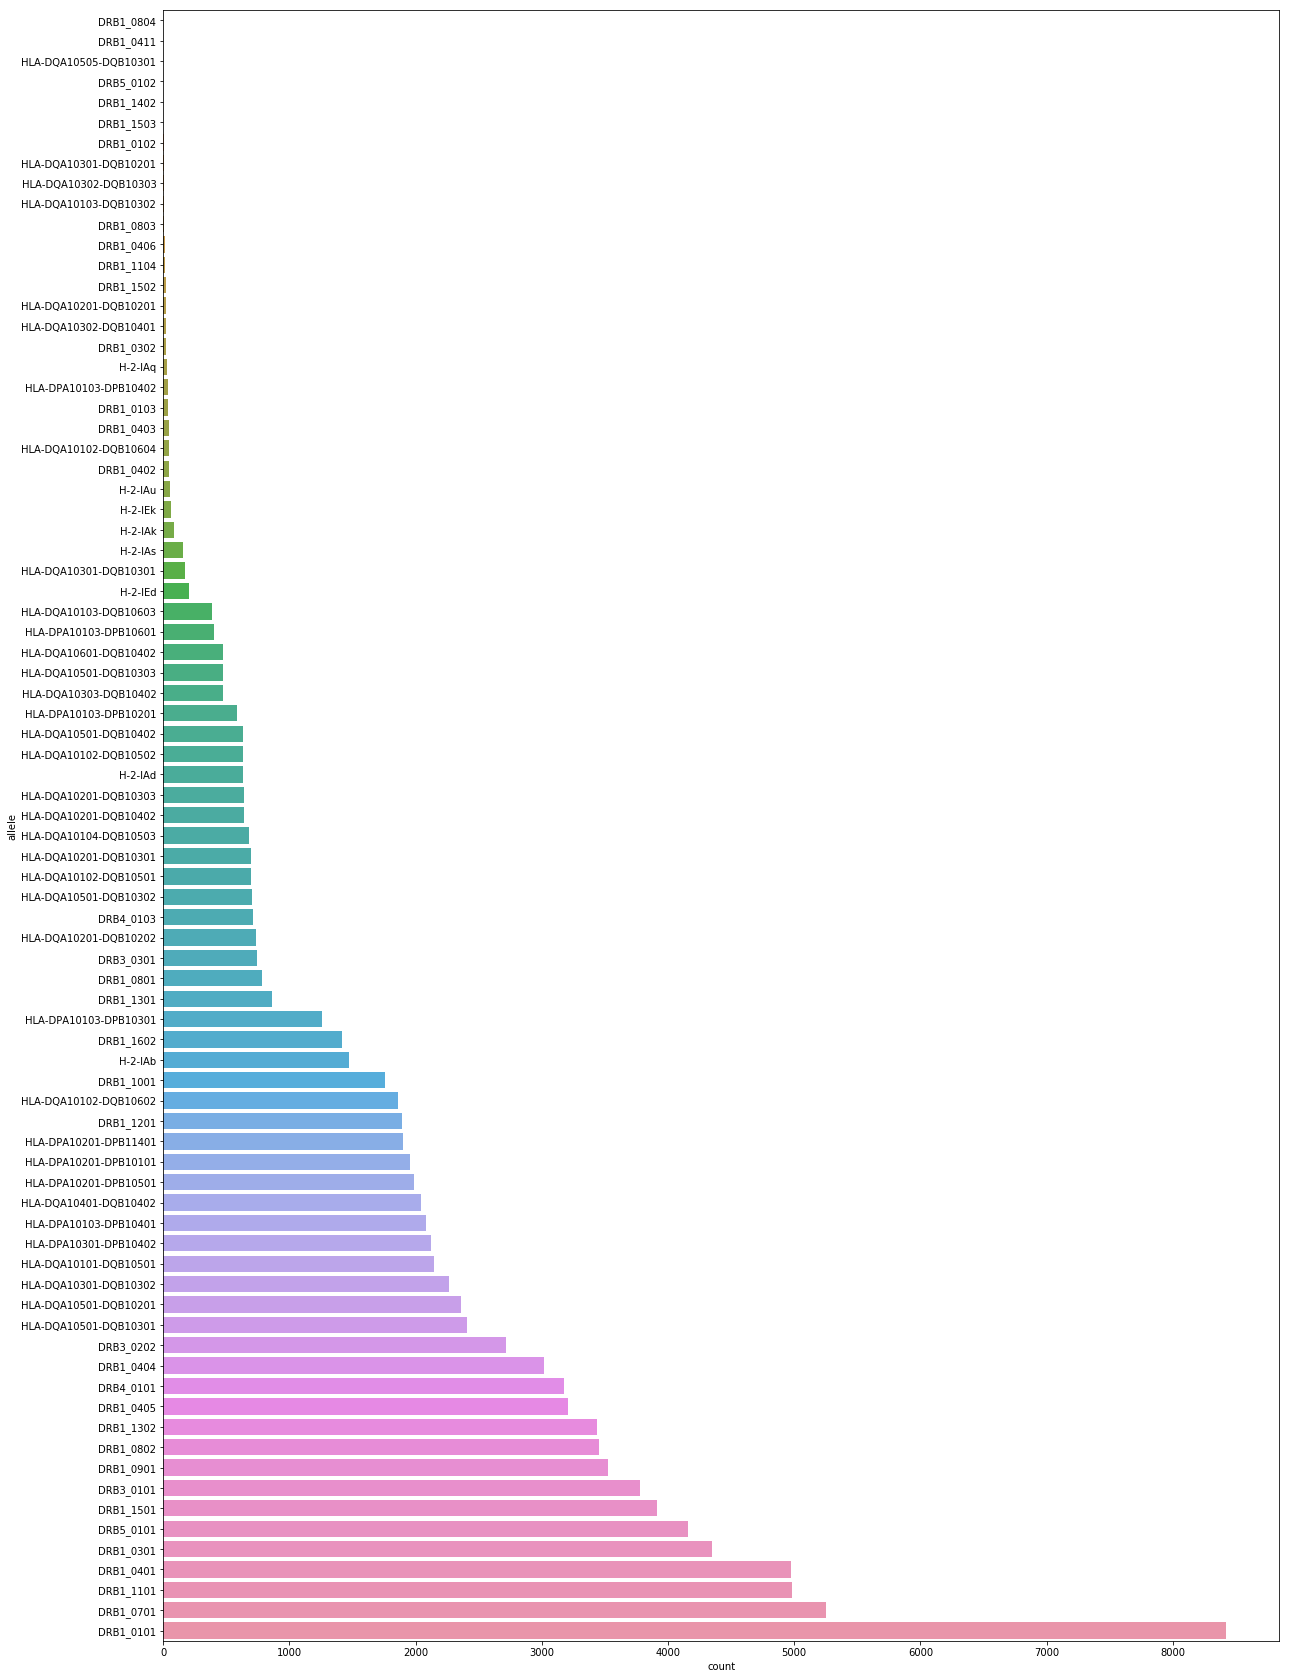

In [18]:
#Train set
plt.figure(figsize=(20,30))
sns.countplot(y='allele', 
              data = train,
              order = train['allele'].value_counts(ascending=True).index)

In [9]:
train = pd.read_csv('/home/pbryant/MHCII/pan/train.csv')
Counter(train['allele'])
alleles

['HLA-DPA10103-DPB10201',
 'HLA-DPA10103-DPB10301',
 'HLA-DPA10103-DPB10401',
 'HLA-DPA10103-DPB10402',
 'HLA-DPA10103-DPB10601',
 'HLA-DPA10201-DPB10101',
 'HLA-DPA10201-DPB10501',
 'HLA-DPA10201-DPB11401',
 'HLA-DPA10301-DPB10402',
 'HLA-DQA10101-DQB10501',
 'HLA-DQA10102-DQB10501',
 'HLA-DQA10102-DQB10502',
 'HLA-DQA10102-DQB10602',
 'HLA-DQA10102-DQB10604',
 'HLA-DQA10103-DQB10302',
 'HLA-DQA10103-DQB10603',
 'HLA-DQA10104-DQB10503',
 'HLA-DQA10201-DQB10201',
 'HLA-DQA10201-DQB10202',
 'HLA-DQA10201-DQB10301',
 'HLA-DQA10201-DQB10303',
 'HLA-DQA10201-DQB10402',
 'HLA-DQA10301-DQB10301',
 'HLA-DQA10301-DQB10302',
 'HLA-DQA10302-DQB10303',
 'HLA-DQA10302-DQB10401',
 'HLA-DQA10303-DQB10402',
 'HLA-DQA10401-DQB10402',
 'HLA-DQA10501-DQB10201',
 'HLA-DQA10501-DQB10301',
 'HLA-DQA10501-DQB10302',
 'HLA-DQA10501-DQB10303',
 'HLA-DQA10501-DQB10402',
 'HLA-DQA10505-DQB10301',
 'HLA-DQA10601-DQB10402',
 'DRB1_0101',
 'DRB1_0102',
 'DRB1_0103',
 'DRB1_0301',
 'DRB1_0302',
 'DRB1_0401',
 'DRB1

In [5]:
HLADICT = {'DRB1_0401': 'MVCLKFPGGSCMAALTVTLMVLSSPLALAGDTRPRFLEQVKHECHFFNGTERVRFLDRYFYHQEEYVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQKRAAVDTYCRHNYGVGESFTVQRRVYPEVTVYPAKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKTGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSLTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_0701': 'MVCLKLPGGSCMAALTVTLMVLSSPLALAGDTQPRFLWQGKYKCHFFNGTERVQFLERLFYNQEEFVRFDSDVGEYRAVTELGRPVAESWNSQKDILEDRRGQVDTVCRHNYGVGESFTVQRRVHPEVTVYPAKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVMSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB3_0301': 'MVCLKLPGGSSLAALTVTLMVLSSRLAFAGDTRPRFLELLKSECHFFNGTERVRFLERYFHNQEEFVRFDSDVGEYRAVTELGRPVAESWNSQKDLLEQKRGQVDNYCRHNYGVVESFTVQRRVHPQVTVYPAKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_0103': 'MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHFFNGTERVRLLERCIYNQEESVRFDSDVGEYRAVTELGRPDAEYWNSQKDILEDERAAVDTYCRHNYGVGESFTVQRRVEPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_1101': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRFLDRYFYNQEEYVRFDSDVGEFRAVTELGRPDEEYWNSQKDFLEDRRAAVDTYCRHNYGVGESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'DRB3_0202': 'MVCLKLPGGSSLAALTVTLMVLSSRLAFAGDTRPRFLELLKSECHFFNGTERVRFLERHFHNQEEYARFDSDVGEYRAVRELGRPDAEYWNSQKDLLEQKRGQVDNYCRHNYGVGESFTVQRRVHPQVTVYPAKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWSARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_1301': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRFLDRYFHNQEENVRFDSDVGEFRAVTELGRPDAEYWNSQKDILEDERAAVDTYCRHNYGVVESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'DRB1_0301': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRYLDRYFHNQEENVRFDSDVGEFRAVTELGRPDAEYWNSQKDLLEQKRGRVDNYCRHNYGVVESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'DRB1_1302': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRFLDRYFHNQEENVRFDSDVGEFRAVTELGRPDAEYWNSQKDILEDERAAVDTYCRHNYGVGESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'DRB4_0103': 'MVCLKLPGGSCMAALTVTLTVLSSPLALAGDTQPRFLEQAKCECHFLNGTERVWNLIRYIYNQEEYARYNSDLGEYQAVTELGRPDAEYWNSQKDLLERRRAEVDTYCRYNYGVVESFTVQRRVQPKVTVYPSKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSMMSPLTVQWSARSESAQSKMLSGVGGFVLGLLFLGTGLFIYFRNQKGHSGLQPTGLLS',
         'DRB3_0101': 'MVCLKLPGGSSLAALTVTLMVLSSRLAFAGDTRPRFLELRKSECHFFNGTERVRYLDRYFHNQEEFLRFDSDVGEYRAVTELGRPVAESWNSQKDLLEQKRGRVDNYCRHNYGVGESFTVQRRVHPQVTVYPAKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSALTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB4_0101': 'MVCLKLPGGSCMAALTVTLTVLSSPLALAGDTQPRFLEQAKCECHFLNGTERVWNLIRYIYNQEEYARYNSDLGEYQAVTELGRPDAEYWNSQKDLLERRRAEVDTYCRYNYGVVESFTVQRRVQPKVTVYPSKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNSQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSMMSPLTVQWSARSESAQSKMLSGVGGFVLGLLFLGTGLFIYFRNQKGHSGLQPTGLLS',
         'DRB5_0101': 'MVCLKLPGGSYMAKLTVTLMVLSSPLALAGDTRPRFLQQDKYECHFFNGTERVRFLHRDIYNQEEDLRFDSDVGEYRAVTELGRPDAEYWNSQKDFLEDRRAAVDTYCRHNYGVGESFTVQRRVEPKVTVYPARTQTLQHHNLLVCSVNGFYPGSIEVRWFRNSQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRAQSESAQSKMLSGVGGFVLGLLFLGAGLFIYFKNQKGHSGLHPTGLVS',
         'DRB1_0803': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTGECYFFNGTERVRFLDRYFYNQEEYVRFDSDVGEYRAVTELGRPSAEYWNSQKDILEDRRALVDTYCRHNYGVGESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWSARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_1501': 'MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHFFNGTERVRFLDRYFYNQEESVRFDSDVGEFRAVTELGRPDAEYWNSQKDILEQARAAVDTYCRHNYGVVESFTVQRRVQPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFLNGQEEKAGMVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_0101': 'MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHFFNGTERVRLLERCIYNQEESVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAAVDTYCRHNYGVGESFTVQRRVEPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_0801': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTGECYFFNGTERVRFLDRYFYNQEEYVRFDSDVGEYRAVTELGRPSAEYWNSQKDFLEDRRALVDTYCRHNYGVGESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWSARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'DRB1_0404': 'MVCLKFPGGSCMAALTVTLMVLSSPLALAGDTRPRFLEQVKHECHFFNGTERVRFLDRYFYHQEEYVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAAVDTYCRHNYGVVESFTVQRRVYPEVTVYPAKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKTGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSLTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'HLA-DQB10603': 'MSWKKALRIPGDLRVATVTLMLAMLSSLLAEGRDSPEDFVYQFKGMCYFTNGTERVRLVTRHIYNREEYARFDSDVGVYRAVTPQGRPDAEYWNSQKEVLEGTRAELDTVCRHNYEVAFRGILQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPGQIKVRWFRNDQEETAGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQSPITVEWRAQSESAQSKMLSGVGGFVLGLIFLGLGLIIRQRSQKGLLH',
         'DQB10303': 'MSWKKALRIPGGLRVATVTLMLAMLSTPVAEGRDSPEDFVYQFKGMCYFTNGTERVRLVTRYIYNREEYARFDSDVGVYRAVTPLGPPDAEYWNSQKEVLERTRAELDTVCRHNYQLELRTTLQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPAQIKVRWFRNDQEETTGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQNPIIVEWRAQSESAQSKMLSGIGGFVLGLIFLGLGLIIHHRSQKGLLH',
         'DQB1*03:02': 'MSWKKALRIPGGLRVATVTLMLAMLSTPVAEGRDSPEDFVYQFKGMCYFTNGTERVRLVTRYIYNREEYARFDSDVGVYRAVTPLGPPAAEYWNSQKEVLERTRAELDTVCRHNYQLELRTTLQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPAQIKVRWFRNDQEETTGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQNPIIVEWRAQSESAQSKMLSGIGGFVLGLIFLGLGLIIHHRSQKGLLH',
         'HLA-DRB1*09:01': 'MVCLKLPGGSCMAALTVTLMVLSSPLALAGDTQPRFLKQDKFECHFFNGTERVRYLHRGIYNQEENVRFDSDVGEYRAVTELGRPVAESWNSQKDFLERRRAEVDTVCRHNYGVGESFTVQRRVHPEVTVYPAKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVMSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'HLA-DRB1*14:54': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRFLDRYFHNQEEFVRFDSDVGEYRAVTELGRPAAEHWNSQKDLLERRRAEVDTYCRHNYGVVESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'HLA-DQA1*03:01': 'MILNKALMLGALALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQYSHEFDGDEEFYVDLERKETVWQLPLFRRFRRFDPQFALTNIAVLKHNLNIVIKRSNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDEPLLKHWEPEIPTPMSELTETVVCALGLSVGLVGIVVGTVLIIRGLRSVGASRHQGPL',
         'HLA-DQA1*01:02':'MILNKALLLGALALTTVMSPCGGEDIVADHVASCGVNLYQFYGPSGQYTHEFDGDEQFYVDLERKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGQSVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDQPLLKHWEPEIPAPMSELTETVVCALGLSVGLMGIVVGTVFIIQGLRSVGASRHQGPL',
         'DQB1*05:01': 'MSWKKSLRIPGDLRVATVTLMLAILSSSLAEGRDSPEDFVYQFKGLCYFTNGTERVRGVTRHIYNREEYVRFDSDVGVYRAVTPQGRPVAEYWNSQKEVLEGARASVDRVCRHNYEVAYRGILQRRVEPTVTISPSRTEALNHHNLLICSVTDFYPSQIKVRWFRNDQEETAGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQSPITVEWRAQSESAQSKMLSGVGGFVLGLIFLGLGLIIRQRSRKGLLH',
         'HLA-DQA1*06:01':'MILNKALLLGALALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQFTHEFDGDEQFYVDLGRKETVWCLPVLRQFRFDPQFALTNIAVTKHNLNILIKRSNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDEPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVFIIRGLRSVGASRHQGPL',
         'DQB1*04:02': 'MSWKKALRIPGGLRVATVTLMLAMLSTPVAEGRDSPEDFVFQFKGMCYFTNGTERVRGVTRYIYNREEYARFDSDVGVYRAVTPLGRLDAEYWNSQKDILEEDRASVDTVCRHNYQLELRTTLQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPAQIKVRWFRNDQEETTGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQNPIIVEWRAQSESAQSKMLSGIGGFVLGLIFLGLGLIIHHRSQKGLLH',
         'HLA-DQA1*02:01':'MILNKALMLGALALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQFTHEFDGDEEFYVDLERKETVWKLPLFHRLRFDPQFALTNIAVLKHNLNILIKRSNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDEPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVLIIRGLRSVGASRHQGPL',
         'HLA-DQA1*05:01':'MILNKALMLGALALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQYTHEFDGDEQFYVDLGRKETVWCLPVLRQFRFDPQFALTNIAVLKHNLNSLIKRSNSTAATNEVPEVTVFSKSPVTLGQPNILICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTLLPSAEESYDCKVEHWGLDKPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVFIIRGLRSVGASRHQGPL',
         'HLA-DQA1*03:03':'MILNKALMLGALALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQYSHEFDGDEEFYVDLERKETVWQLPLFRRFRRFDPQFALTNIAVLKHNLNIVIKRSNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTFLPSDDEIYDCKVEHWGLDEPLLKHWEPEIPTPMSELTETVVCALGLSVGLVGIVVGTVLIIRGLRSVGASRHQGPL',
         'DQB1*03:01': 'MSWKKALRIPGGLRAATVTLMLAMLSTPVAEGRDSPEDFVYQFKAMCYFTNGTERVRYVTRYIYNREEYARFDSDVEVYRAVTPLGPPDAEYWNSQKEVLERTRAELDTVCRHNYQLELRTTLQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPAQIKVRWFRNDQEETTGVVSTPLIRNGDWTFQILVMLEMTPQHGDVYTCHVEHPSLQNPITVEWRAQSESAQSKMLSGIGGFVLGLIFLGLGLIIHHRSQKGLLH',
         'DQB1*06:04': 'MSWKKALRIPGDLRVATVTLMLAMLSSLLAEGRDSPEDFVYQFKGMCYFTNGTERVRLVTRHIYNREEYARFDSDVGVYRAVTPQGRPVAEYWNSQKEVLERTRAELDTVCRHNYEVGYRGILQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPGQIKVQWFRNDQEETAGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQSPITVEWRAQSESAQSKMLSGVGGFVLGLIFLGLGLIIRQRSQKGLLH',
         'DQB1*06:02': 'MSWKKALRIPGDLRVATVTLMLAMLSSLLAEGRDSPEDFVFQFKGMCYFTNGTERVRLVTRYIYNREEYARFDSDVGVYRAVTPQGRPDAEYWNSQKEVLEGTRAELDTVCRHNYEVAFRGILQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPGQIKVRWFRNDQEETAGVVSTPLIRNGDWTFQILVMLEMTPQRGDVYTCHVEHPSLQSPITVEWRAQSESAQSKMLSGVGGFVLGLIFLGLGLIIRQRSQKGLLH',
         'HLA-DQA1*05:05':'MILNKALMLGTLALTTVMSPCGGEDIVADHVASYGVNLYQSYGPSGQYTHEFDGDEQFYVDLGRKETVWCLPVLRQFRFDPQFALTNIAVLKHNLNSLIKRSNSTAATNEVPEVTVFSKSPVTLGQPNILICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTLLPSAEESYDCKVEHWGLDKPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVFIIRGLRSVGASRHQGPL',
         'HLA-DQA1*01:01':'MILNKALLLGALALTTVMSPCGGEDIVADHVASCGVNLYQFYGPSGQYTHEFDGDEEFYVDLERKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGQSVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDQPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVFIIQGLRSVGASRHQGPL',
         'HLA-DQA1*03:02':'MILNKALMLGALALTTVTSPCGGEDIVADHVASYGVNLYQSYGPSGQYSHEFDGDEEFYVDLERKETVWQLPLFRRFRRFDPQFALTNIAVLKHNLNIVIKRSNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHSVTEGVSETSFLSKSDHSFFKISYLTFLPSDDEIYDCKVEHWGLDEPLLKHWEPEIPTPMSELTETVVCALGLSVGLVGIVVGTVLIIRGLRSVGASRHQGPL',
         'HLA-DQA1*01:03':'MILNKALLLGALALTTVMSPCGGEDIVADHVASCGVNLYQFYGPSGQFTHEFDGDEQFYVDLEKKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNSTAATNEVPEVTVFSKSPVTLGQPNTLICLVDNIFPPVVNITWLSNGHAVTEGVSETSFLSKSDHSFFKISYLTFLPSADEIYDCKVEHWGLDQPLLKHWEPEIPAPMSELTETVVCALGLSVGLVGIVVGTVFIIQGLRSVGASRHQGPL',
         'HLA-DRB1*04:05': 'MVCLKFPGGSCMAALTVTLMVLSSPLALAGDTRPRFLEQVKHECHFFNGTERVRFLDRYFYHQEEYVRFDSDVGEYRAVTELGRPSAEYWNSQKDLLEQRRAAVDTYCRHNYGVGESFTVQRRVYPEVTVYPAKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKTGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSLTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'HLA-DRB1*10:01': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEEVKFECHFFNGTERVRLLERRVHNQEEYARYDSDVGEYRAVTELGRPDAEYWNSQKDLLERRRAAVDTYCRHNYGVGESFTVQRRVQPKVTVYPSKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKTGVVSTGLIQNGDWTFQTLVMLETVPQSGEVYTCQVEHPSVMSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLPPTGFLS',
         'HLA-DRB1*04:03': 'MVCLKFPGGSCMAALTVTLMVLSSPLALAGDTRPRFLEQVKHECHFFNGTERVRFLDRYFYHQEEYVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAEVDTYCRHNYGVVESFTVQRRVYPEVTVYPAKTQPLQHHNLLVCSVNGFYPGSIEVRWFRNGQEEKTGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSLTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'HLA-DRB1*11:04': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTSECHFFNGTERVRFLDRYFYNQEEYVRFDSDVGEFRAVTELGRPDEEYWNSQKDFLEDRRAAVDTYCRHNYGVVESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPRGFLS',
         'HLA-DRB1*15:02': 'MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHFFNGTERVRFLDRYFYNQEESVRFDSDVGEFRAVTELGRPDAEYWNSQKDILEQARAAVDTYCRHNYGVGESFTVQRRVQPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFLNGQEEKAGMVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS',
         'HLA-DRB1*08:02': 'MVCLRLPGGSCMAVLTVTLMVLSSPLALAGDTRPRFLEYSTGECYFFNGTERVRFLDRYFYNQEEYVRFDSDVGEYRAVTELGRPDAEYWNSQKDFLEDRRALVDTYCRHNYGVGESFTVQRRVHPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWSARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS'
          
          }

In [7]:
HLADICT['DRB1_0102']

KeyError: 'DRB1_0102'

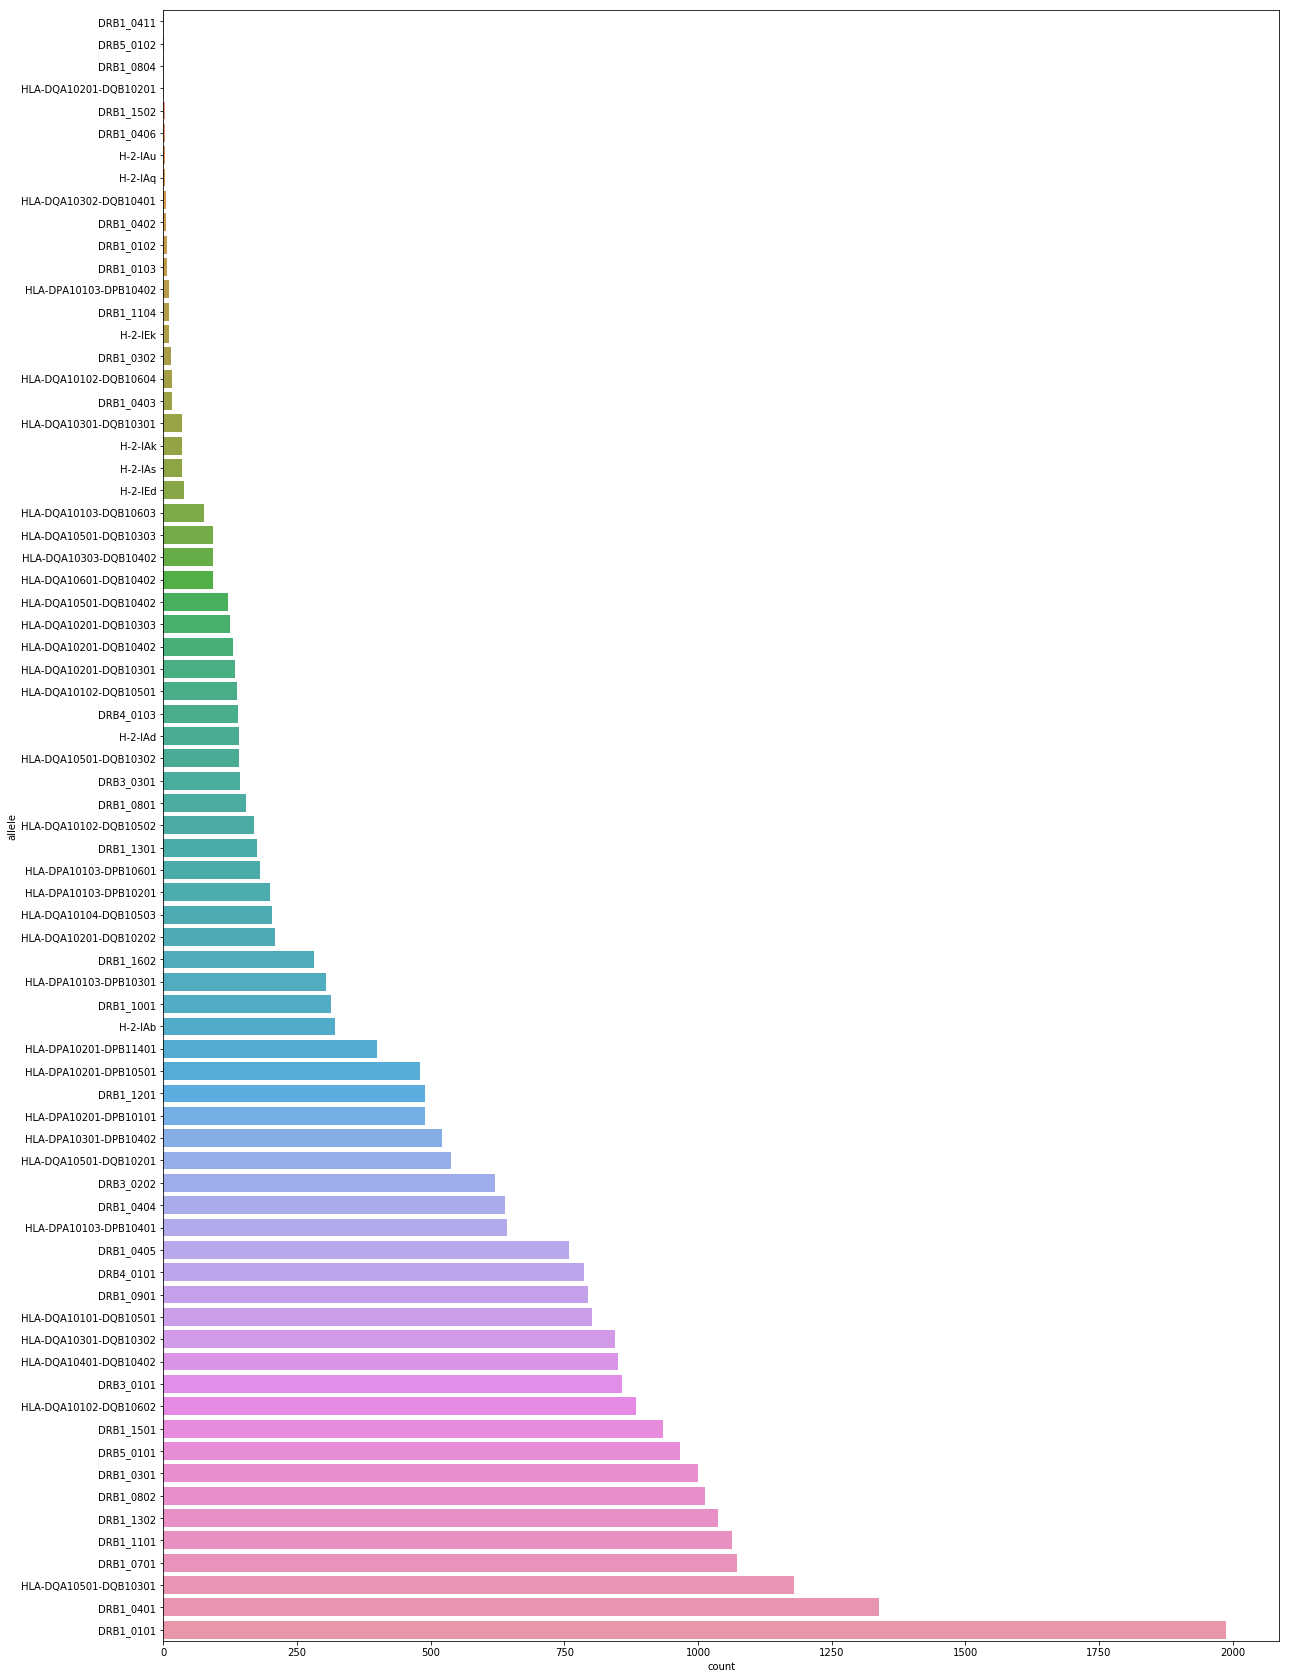

In [19]:
#Test set
plt.figure(figsize=(20,30))
sns.countplot(y='allele', 
              data = test,
              order = test['allele'].value_counts(ascending=True).index)

In [25]:
#Has to start at 0, since Keras apparently uses the index for lookup
AMINO_ACIDS = { 
'A':0,
'R':1,
'N':2,
'D':3,
'C':4,
'E':5,
'Q':6,
'G':7,
'H':8,
'I':9,
'L':10,
'K':11,
'M':12,
'F':13,
'P':14,
'S':15,
'T':16,
'W':17,
'Y':18,
'V':19,
#'X':20, #UNKNOWN
'-':20
}
def encode_aa(sequence):
    enc = []
    for a in sequence:
        try:
            enc.append(AMINO_ACIDS[a])
        except:
            pdb.set_trace()
    return enc

In [51]:
#Encode amino acids for train set
peptide_enc = []
for index, row in train.iterrows():
    seq = row['peptide_seq']
    enc = encode_aa(seq)
    peptide_enc.append(np.asarray(enc))
    
peptide_enc = np.asarray(peptide_enc)
np.save('/home/pbryant/MHCII/pan/train_aa_enc.npy', peptide_enc)

In [52]:
#Encode amino acids for test set
peptide_enc = []
for index, row in test.iterrows():
    seq = row['peptide_seq']
    enc = encode_aa(seq)
    peptide_enc.append(np.asarray(enc))
    
peptide_enc = np.asarray(peptide_enc)
np.save('/home/pbryant/MHCII/pan/test_aa_enc.npy', peptide_enc)

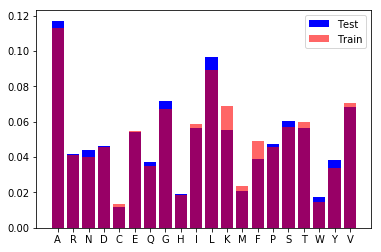

In [108]:
#test aa counts
aa_enc = np.load('/home/pbryant/MHCII/pan/test_aa_enc.npy', allow_pickle = True)
aa_dict = dict(zip(range(0,20),np.zeros(20))) #Create dict to save counts
for x in aa_enc:
    c = Counter(x)
    for key in [*c.keys()]:
        aa_dict[key] += c[key]

back = { 0:'A',1:'R',2:'N',3:'D',4:'C',5:'E',6:'Q',7:'G',8:'H',9:'I',10:'L',11:'K',12:'M',13:'F',
14:'P',15:'S',16:'T',17:'W',18:'Y',19:'V'}

aa_sums = []
aa = []
for key in aa_dict:
    aa.append(back[key])
    aa_sums.append(aa_dict[key])
aa_sums = aa_sums/np.sum(aa_sums)
ax = plt.subplot()
ax.bar(aa, aa_sums, color = 'b', label = 'Test')

#train aa counts
aa_enc = np.load('/home/pbryant/MHCII/pan/train_aa_enc.npy', allow_pickle = True)
aa_dict = dict(zip(range(0,20),np.zeros(20))) #Create dict to save counts
for x in aa_enc:
    c = Counter(x)
    for key in [*c.keys()]:
        aa_dict[key] += c[key]

back = { 0:'A',1:'R',2:'N',3:'D',4:'C',5:'E',6:'Q',7:'G',8:'H',9:'I',10:'L',11:'K',12:'M',13:'F',
14:'P',15:'S',16:'T',17:'W',18:'Y',19:'V'}

aa_sums = []
aa = []
for key in aa_dict:
    aa.append(back[key])
    aa_sums.append(aa_dict[key])
aa_sums = aa_sums/np.sum(aa_sums)
ax.bar(aa, aa_sums, color = 'r', label = 'Train', alpha = 0.6)

plt.legend()

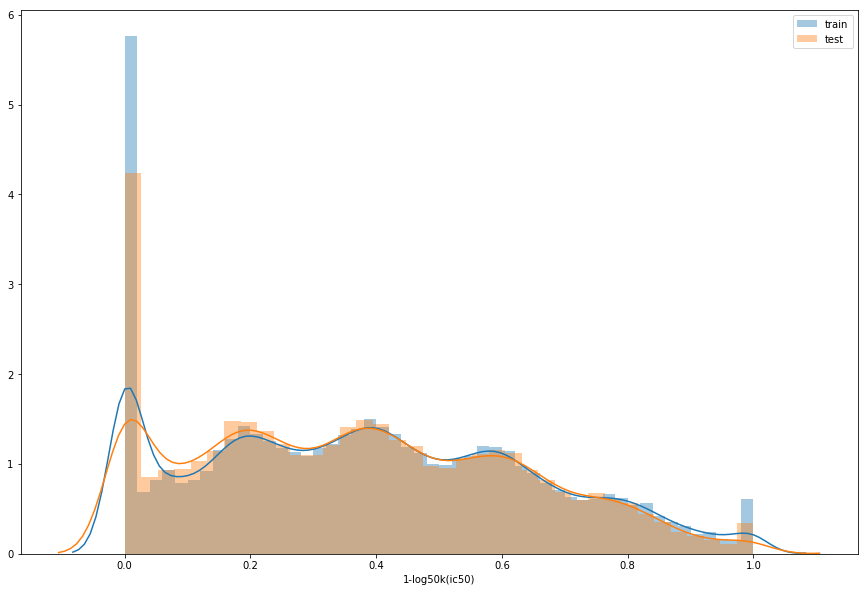

In [136]:
#look into log50k vals
#When classifying the peptides into binders and non-binders for calculation of the AUC values for instance, 
#a threshold of 500 nM is used. This means that peptides with log50k 
#transformed binding affinity values greater than 0.426 are classified as binders.
plt.figure(figsize=(15,10))
sns.distplot(train['log50k'], label = 'train')
sns.distplot(test['log50k'], label = 'test')
plt.xlabel('1-log50k(ic50)')
plt.legend()

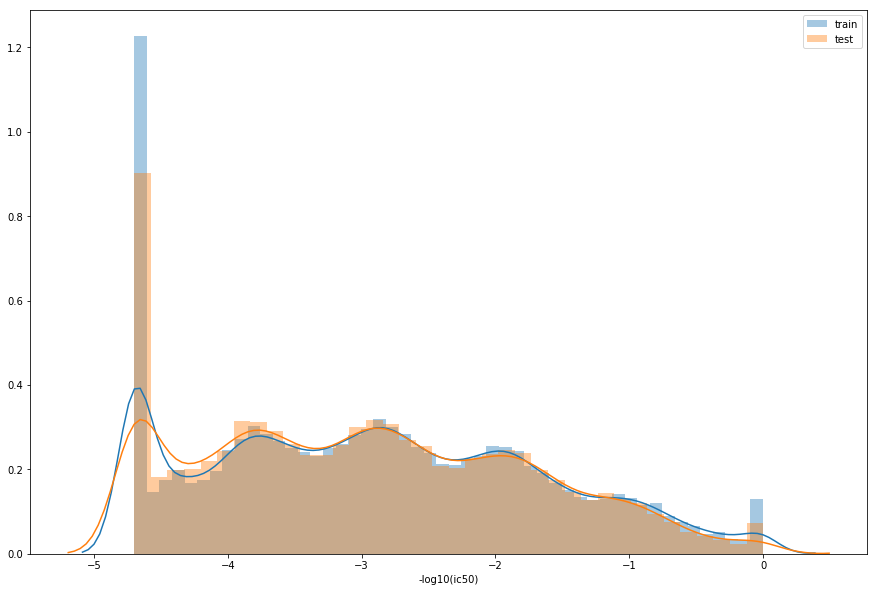

In [135]:
#Convert back to nM to use pIC50
#Train data
#1 - log50k( aff nM))
tr = np.asarray(train['log50k'])
tr = np.power(50000, (1-tr))
#Convert to pic50 = -log10(ic50)
tr = -np.log10(tr)
plt.figure(figsize=(15,10))
sns.distplot(tr, label = 'train')

#Test data
ts = np.asarray(test['log50k'])
ts = np.power(50000, (1-ts))
#Convert to pic50 = -log10(ic50)
ts = -np.log10(ts)
sns.distplot(ts, label = 'test')
plt.xlabel('-log10(ic50)')
plt.legend()

37 35
9 9


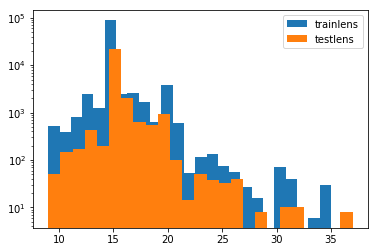

In [158]:
#Look into lengths of peptide sequences
trainseqs = train['peptide_seq']
trainlens = []
for s in trainseqs:
    trainlens.append(len(s))
testseqs = test['peptide_seq']
testlens = []
for s in testseqs:
    testlens.append(len(s))

plt.yscale('log')
plt.hist(trainlens, bins = 25, label = 'trainlens')
plt.hist(testlens, bins = 25, label = 'testlens')
plt.legend()

print(max(testlens), max(trainlens))
print(min(testlens), min(trainlens))


In [210]:
#Looking into the t-cell evaluation data
alleles = []
pepseqs = []
epseqs = []

def fix_allele_name(allele):
    if 'DR' in allele:
        allele = allele[0:4]+'_'+allele[4:-3]+allele[-2:]
    else:
        allele = allele[0:-3]+allele[-2:]
    return allele

with open('/home/pbryant/data/MHCII/panmhc/tcell_eval.fa', 'r') as file:
    sequence = ''
    for line in file:
        line = line.rstrip()
        if line[0] == '>':
            if len(sequence)>0:
                epseqs.append(sequence) 
            line = line.split('|')
            line = line[0].split('=')
            pepseq = line[1]
            pepseqs.append(pepseq)
            allele = line[2].split()[0]
            if 'DR' in allele:
                allele = allele[4:]
            if '/' in allele:
                allele = allele.split('/')
                allele = fix_allele_name(allele[0])+'-'+fix_allele_name(allele[1])
            if ':' in allele:
                allele = fix_allele_name(allele)
            if allele[0:2] == 'H2':
                allele = allele[0]+'-'+allele[1:]
                
            alleles.append(allele)
            #Reset sequence
            sequence = ''
        else:
            sequence += line
    epseqs.append(sequence)    
tcell_df = pd.DataFrame(list(zip(alleles, pepseqs, epseqs)), columns = ['allele','peptide_seq', 'epitope_seq'])
tcell_df.to_csv('/home/pbryant/MHCII/pan/tcell.csv')

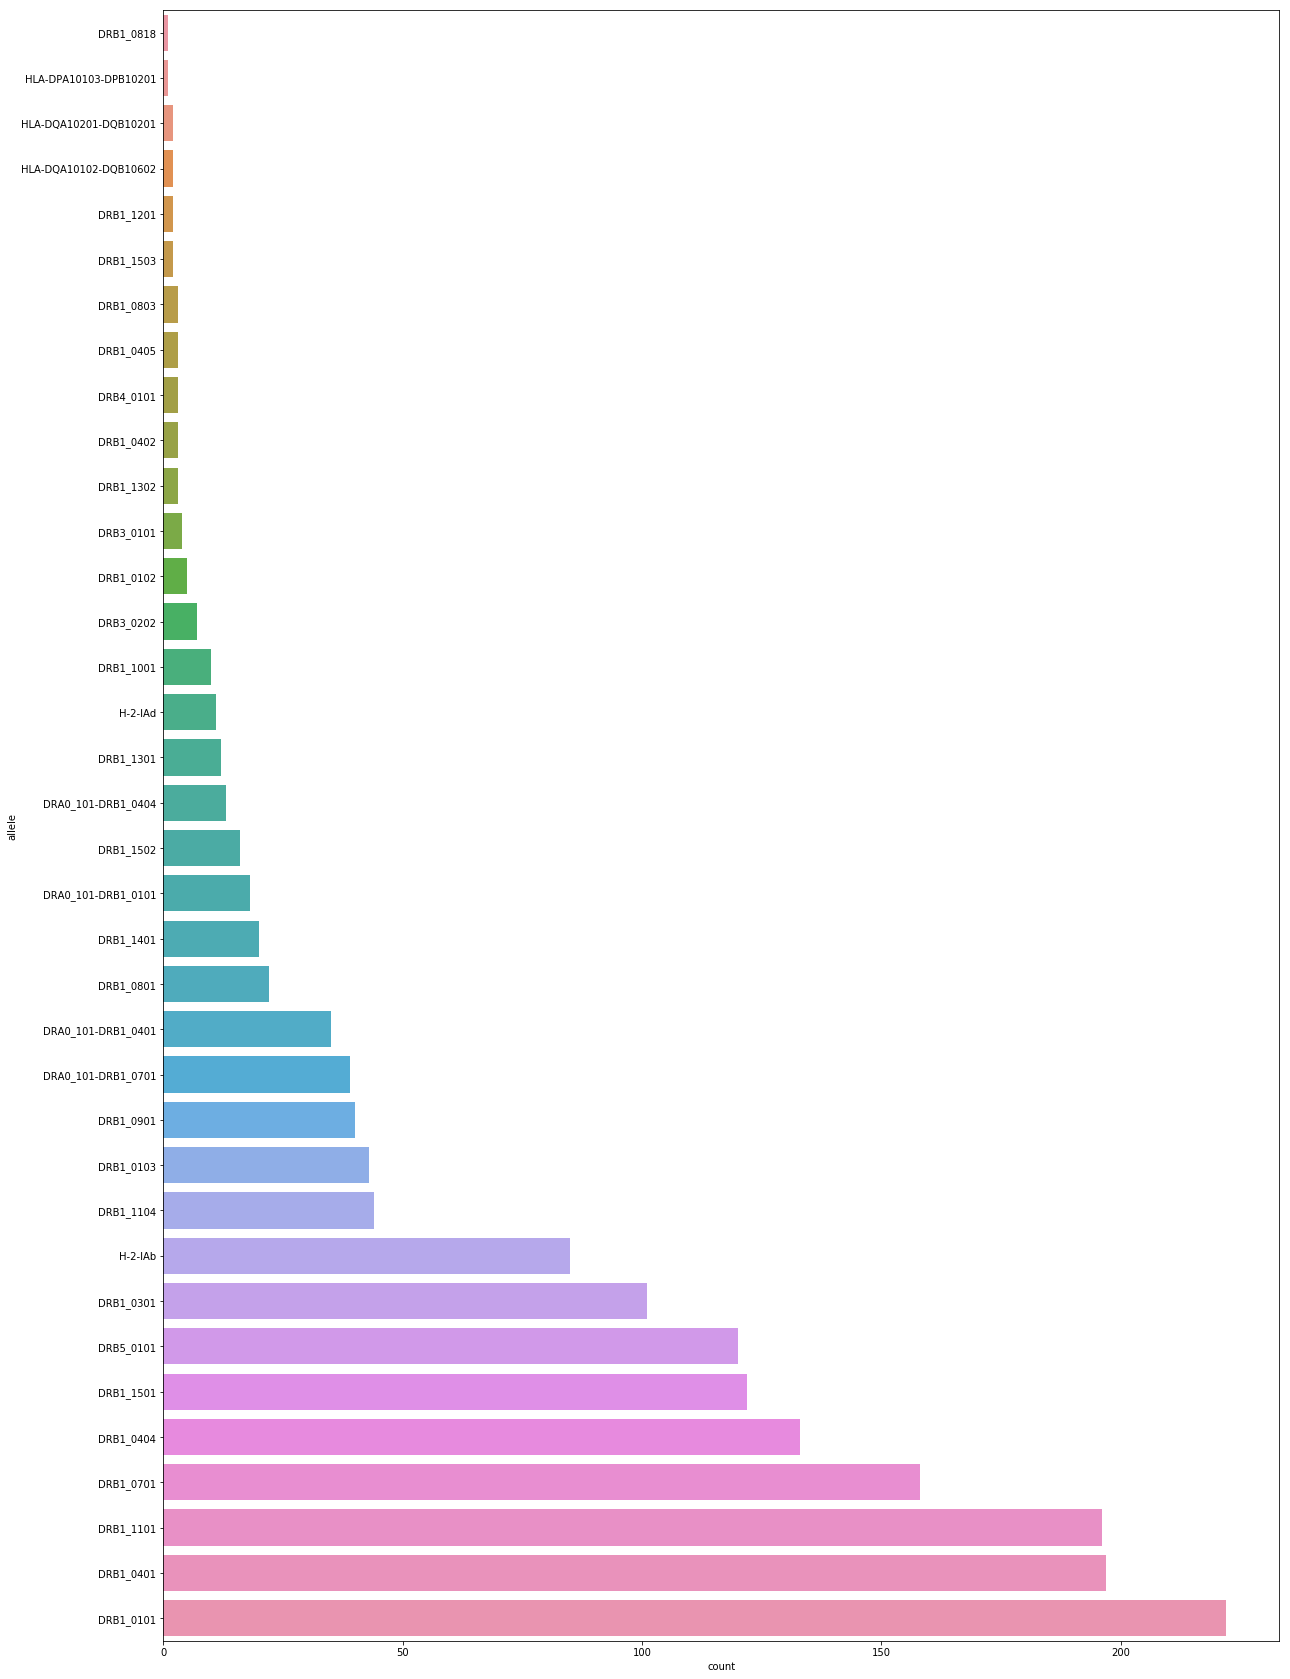

In [209]:
#Count alleles
plt.figure(figsize=(20,30))
sns.countplot(y='allele', 
              data = tcell_df,
              order = tcell_df['allele'].value_counts(ascending=True).index)

In [205]:
tcell_alleles = Counter(alleles)
tcell_alleles

Counter({'H-2-IAb': 85,
         'DRA0_101-DRB1_0701': 39,
         'DRB5_0101': 120,
         'HLA-DQA10102-DQB10602': 2,
         'DRB1_1104': 44,
         'DRB1_0101': 222,
         'DRB1_0301': 101,
         'DRB1_0401': 197,
         'DRA0_101-DRB1_0401': 35,
         'DRB1_1101': 196,
         'DRB1_1501': 122,
         'DRB1_1001': 10,
         'DRA0_101-DRB1_0404': 13,
         'DRB1_0404': 133,
         'DRB1_0901': 40,
         'DRB1_0102': 5,
         'DRB1_0701': 158,
         'H-2-IAd': 11,
         'DRB3_0202': 7,
         'DRA0_101-DRB1_0101': 18,
         'DRB1_0405': 3,
         'DRB1_1401': 20,
         'DRB1_0103': 43,
         'DRB1_1502': 16,
         'DRB1_0402': 3,
         'DRB1_0801': 22,
         'DRB4_0101': 3,
         'DRB1_1301': 12,
         'DRB1_1201': 2,
         'DRB1_1302': 3,
         'HLA-DQA10201-DQB10201': 2,
         'DRB3_0101': 4,
         'DRB1_0803': 3,
         'DRB1_0818': 1,
         'DRB1_1503': 2,
         'HLA-DPA10103-DPB10201': 1})

In [206]:
#These alleles are not in the training dataset
for a in [*tcell_alleles.keys()]:
    if a not in [*allele_enc.keys()]:
        print(a, tcell_alleles[a])
    

DRA0_101-DRB1_0701 39
DRA0_101-DRB1_0401 35
DRA0_101-DRB1_0404 13
DRA0_101-DRB1_0101 18
DRB1_1401 20
DRB1_0818 1


In [216]:
peplens = []
for i in range(len(tcell_df)):
    l = len(tcell_df.iloc[0]['peptide_seq'])
    peplens.append(l)
tcell_df['peplen'] = peplens
tcell_df.to_csv('/home/pbryant/MHCII/pan/tcell.csv')

In [220]:
 tcell_df

,allele,peptide_seq,epitope_seq,peplens,peplen
0,H-2-IAb,AAHAEINEA,GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAK...,9,9
1,H-2-IAb,ISQAVHAAHAEINEAGR,GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAK...,9,9
2,DRA0_101-DRB1_0701,IYWTIVKPGDILL,QNLPGNDNSTATLCLGHHAVPNGTLVKTITNDQIEVTNATELVQSS...,9,9
3,DRB5_0101,DESERMRKVLENRSLSDEER,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
4,HLA-DQA10102-DQB10602,EDLERSEERLNTATTKLAEA,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
5,DRB1_1104,EEVHNLQKRMQQLENDLDQV,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
6,DRB5_0101,ENQLKEARFLAEEADRKYDE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
7,DRB5_0101,KYDEVARKLAMVEADLERAE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
8,DRB5_0101,LAMVEADLERAEERAETGES,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9
9,DRB1_0101,LEEELRVVGNNLKSLEVSEE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9


In [230]:
decoys = []
for i in range(len(tcell_df)):
    row = tcell_df.iloc[i]
    seq = row['epitope_seq']
    d = []
    p = int(row['peplen']) #length of peptide
    for j in range(0,len(seq)):
        d.append(seq[j:j+p])
    decoys.append(d)


In [238]:
tcell_df['epitope_split'] = decoys
tcell_df.to_csv('/home/pbryant/MHCII/pan/tcell.csv')

In [239]:
tcell_df

,allele,peptide_seq,epitope_seq,peplens,peplen,epitope_split
0,H-2-IAb,AAHAEINEA,GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAK...,9,9,"[GSIGAASME, SIGAASMEF, IGAASMEFC, GAASMEFCF, A..."
1,H-2-IAb,ISQAVHAAHAEINEAGR,GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAK...,9,9,"[GSIGAASME, SIGAASMEF, IGAASMEFC, GAASMEFCF, A..."
2,DRA0_101-DRB1_0701,IYWTIVKPGDILL,QNLPGNDNSTATLCLGHHAVPNGTLVKTITNDQIEVTNATELVQSS...,9,9,"[QNLPGNDNS, NLPGNDNST, LPGNDNSTA, PGNDNSTAT, G..."
3,DRB5_0101,DESERMRKVLENRSLSDEER,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
4,HLA-DQA10102-DQB10602,EDLERSEERLNTATTKLAEA,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
5,DRB1_1104,EEVHNLQKRMQQLENDLDQV,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
6,DRB5_0101,ENQLKEARFLAEEADRKYDE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
7,DRB5_0101,KYDEVARKLAMVEADLERAE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
8,DRB5_0101,LAMVEADLERAEERAETGES,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
9,DRB1_0101,LEEELRVVGNNLKSLEVSEE,MDAIKKKMQAMKLEKDNAMDRADTLEQQNKEANNRAEKSEEEVHNL...,9,9,"[MDAIKKKMQ, DAIKKKMQA, AIKKKMQAM, IKKKMQAMK, K..."
